## 1. Overview
This file contains the code for the forward model described in section 2.2 of the paper. It is used to generate the observations for the inverse model. 

## 2. Set-up 

In [1]:
# Import general libraries
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

The land surface model is solved using Finite Difference Method. We use a central finite difference discretisation in space and a backward Euler discretisation in time. HFirst we create the discretised space and time arrays. 

In [2]:
# Space discretisation 
Nx = 101 # no. of space intervals 
xa = 0 
xb = 1 #total depth (m) 
x = np.linspace(xa, xb, Nx) # create x array
dx = (xb-xa)/(Nx-1) # calculate space increment

# Time discretisation
hour = 3600 # no. of seconds in an hour 
dt = hour; # length of time interval 
Nt = 100; # no. of time intervals 
t_total = Nt*dt; # total time 
time_1hr = np.linspace(0, t_total,Nt+1);

trise = 7*hour #time of sunrise 
tset = 21*hour #time of sunset 

# Time in terms of solar zenith angle theta 
t24 = np.mod(time_1hr, 24*hour);
theta=(t24-trise)/(tset-trise)*np.pi/2 + (t24-tset)/(tset-trise)*np.pi/2;
for i in range(Nt+1):
    if abs(theta[i]) > np.pi/2:
        theta[i] = theta[i]/abs(theta[i])*np.pi/2


Next we define the constants, the incoming radiations, and the true values for the input parameters. 

In [3]:
#Thermal & radiation properties
Ta = 296 #atmospheric temperature 
epsilon = 0.95 #emissivity 
sigma = 5.67e-8 #Stefan-Boltzmann constant
K_down = 800 #downwelling shortwave radiation
L_down = 100 #downwelling longwave radiation 

# Generating arrays for incoming radiations and amospheric temperature
K_down_array = K_down*np.cos(theta) 
L_down_array = L_down*np.ones(Nt+1) 
Ta_array = Ta*np.ones(Nt+1) 

# Define true values of parameters 
alpha_true = 0.2 
Lambda_true = 0.8 
Tb_true = 293
C_true = 2.2e6
beta_true = 1.5
h_true = 15

## 3. Classes and Functions

This section is where we create the key class and functions that form the forward model. 

### 3.1 Convolution Class
First, we create the convolution Class *HeatEqConv()*. This Class is used to create convolution function which will apply convolution to an input temperature tensor *previous*. 

The Class has two methods. The first one is the initialise method or constructor. In this method, the function *super()* is used to call the *_ init() _* method of base class *nn.Module*. This allows the model to access *nn.Module*’s methods, allowing users to define the common building blocks of neutral network, such as the number of layers, convolution and activation functions. NN4PDES uses the *Conv1d()* class from *nn.Module* to apply discrete convolution to an input tensor. The input tensor and the kernel have three dimensions: (*batch_size*, *in_channels*, *width*). *in_channels* is the number of input channels and *width* is the length of input tensor or kernel sequence. The convolution function is saved in the instance created using the self parameter, so that it can be accessed in the forward method using *self.conv_layer*.

The second method is the forward method, which is where the convolution is applied. 

In [4]:
class HeatEqConv(nn.Module):
    def __init__(self, Nx, filter_weight): #filter_weight
        super(HeatEqConv, self).__init__()

        # Specify the size of the input (batch_size, number of input channels, length of input tensor)
        input_size = (1, 1, Nx)  
        batch_size, in_channels, width = input_size

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]

        # Create a Conv1d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv1d(in_channels, out_channels=1,kernel_size=kernel_size, padding='valid', bias=False)
        self.conv_layer.weight.data = filter_weight

    def forward(self, previous):

        future = self.conv_layer(previous) # previous(1,1,Nx); future(1,1,Nx-2)
        return future

####  3.1.1 Determining the kernel
Rewriting Equation (6) in matrix form will give us a system of linear equations that can be solved using the Jacobi method.

$$
\begin{pmatrix}
-r & 1+2r & -r & 0 & \cdots & 0 \\
0 & -r & 1+2r & -r & \cdots & 0 \\
\vdots & & \ddots & \ddots & \ddots & \vdots \\
0 & 0 & \cdots & -r & 1+2r & -r
\end{pmatrix}
\begin{bmatrix}
T_0 \\
T_1 \\
T_2 \\
\vdots \\
T_N
\end{bmatrix}^{n+1}
=
\begin{bmatrix}
T_1 \\
T_2 \\
\vdots \\
T_{N-1}
\end{bmatrix}^n
$$


Rearranging the terms, we have the $k+1^{th}$ approximation of $T_i^{n+1}$:

$$

\begin{bmatrix}
T_1 \\
T_2 \\
\vdots \\
T_{N-1}
\end{bmatrix}^n
+
\begin{pmatrix}
r & 0 & r &\cdots & 0 \\
0 & r & 0 & \cdots & 0 \\
\vdots & & & \ddots & \\
0 & 0 & 0 & \cdots & r
\end{pmatrix}
\begin{bmatrix}
T_0 \\
T_1 \\
T_2 \\
\vdots \\
T_N
\end{bmatrix}^{n+1,(k)}
=
\begin{pmatrix}
1 + 2r & & & 0 \\
& 1 + 2r & & \\
& & \ddots & \\
0 & & & 1 + 2r
\end{pmatrix}
\begin{bmatrix}
T_1 \\
T_2 \\
\vdots \\
T_{N-1}
\end{bmatrix}^{n+1,(k+1)}
$$

The application of kernel $[r,0,r]$ is illustrated in the below schematic 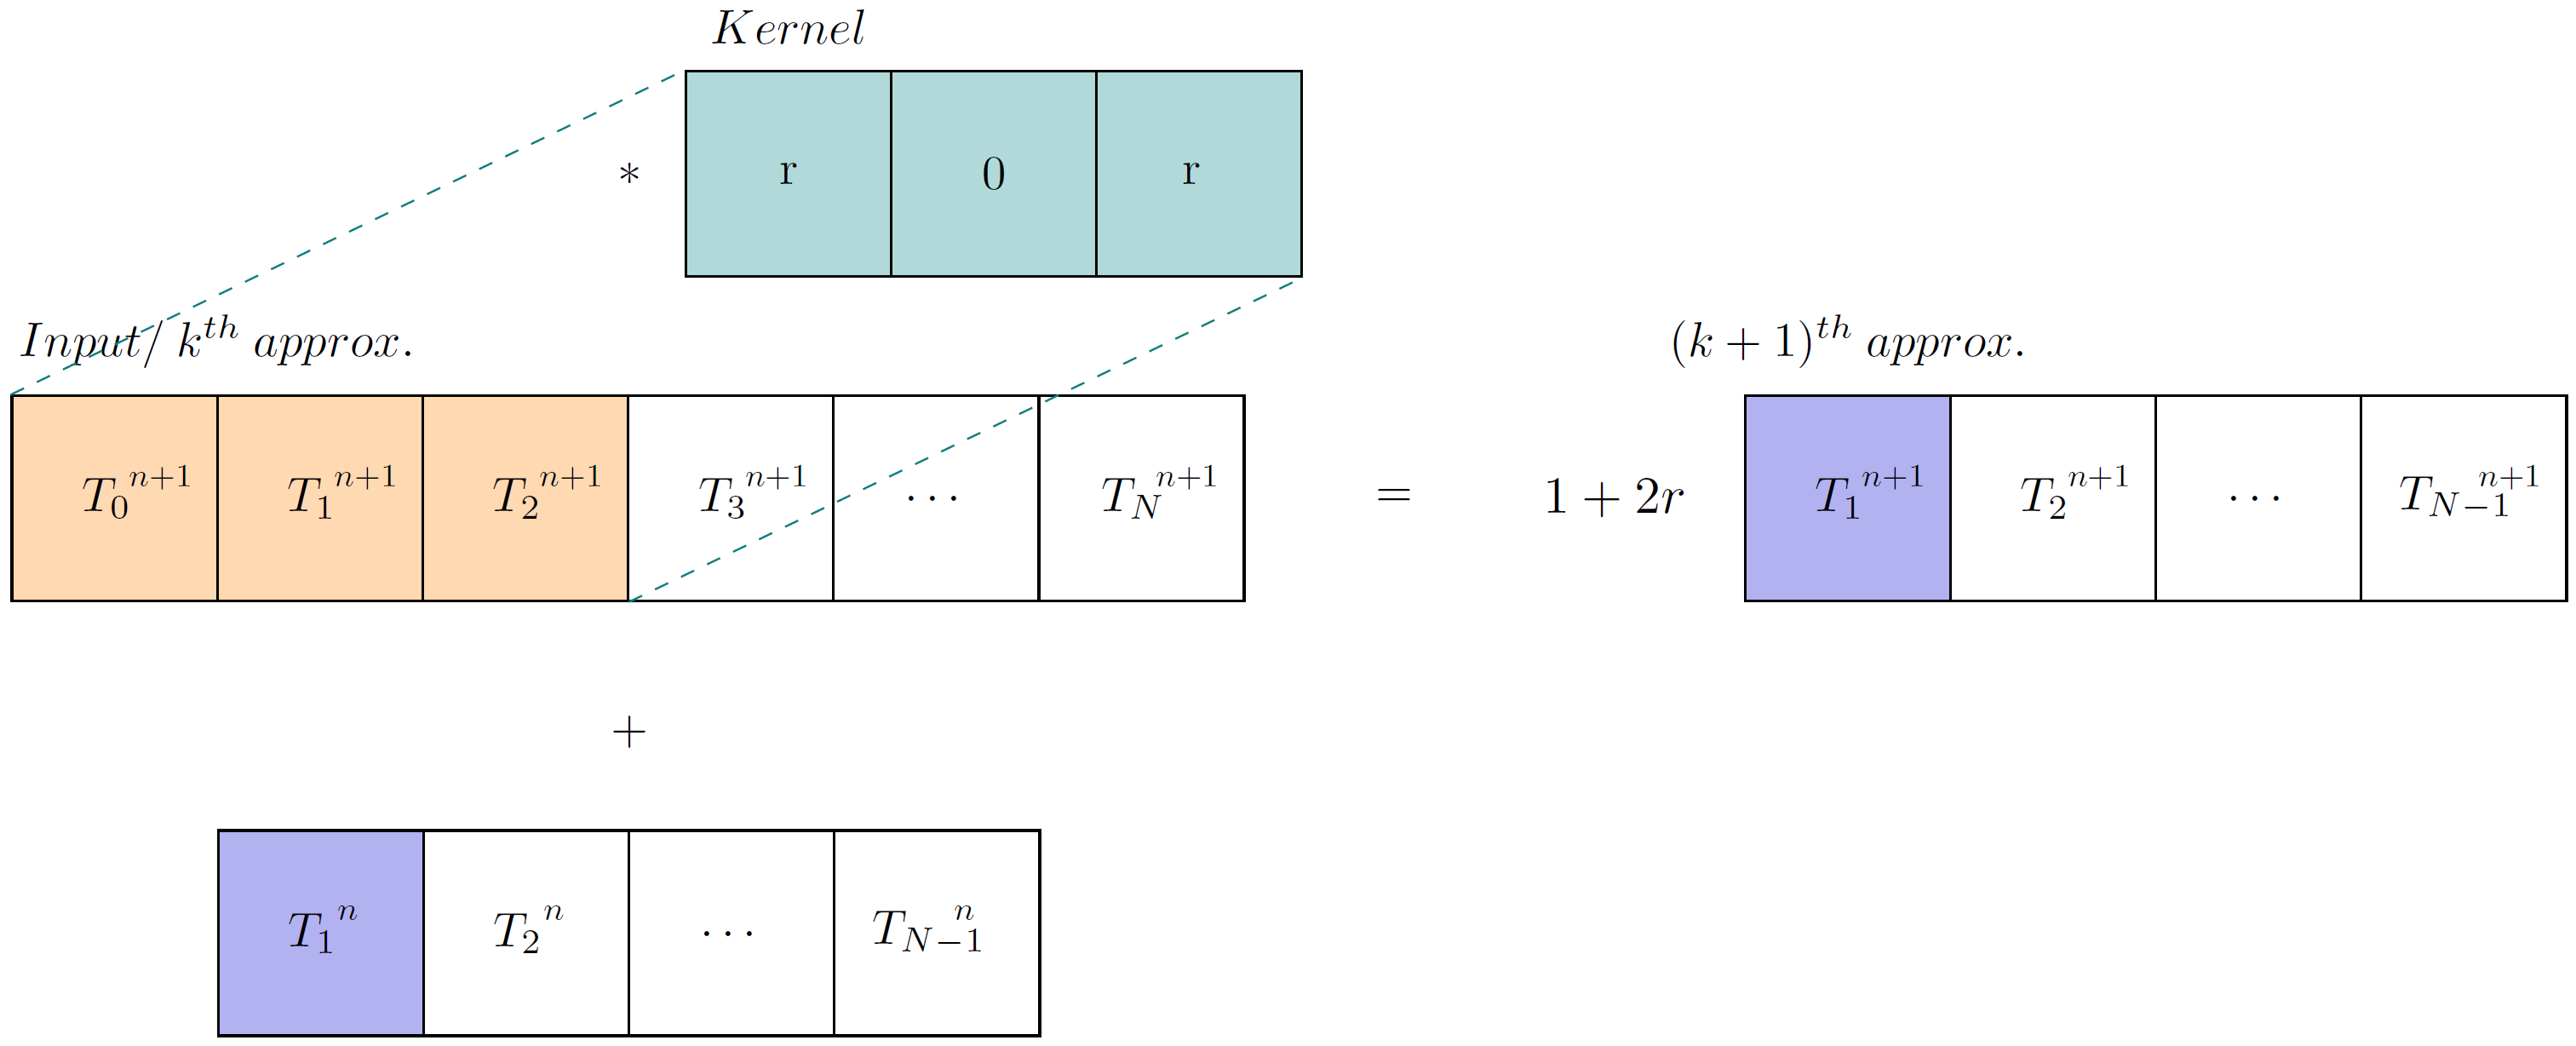

In [5]:
# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(np.array(x), dtype=torch.float64)

# filter corresponding to the above kernel. r will be calculated and applied in the solver in the next section
filter = torch.tensor([1, 0., 1], dtype=torch.float64)

# resize filter for PyTorch
# filter_weight(num_kernels/output channels, kernel_height, kernel_width)
filter_weight = filter.view(1, 1, filter.shape[0])

# Create instance of convolution and use it as a function to apply convolution
mymodel_time_march = HeatEqConv(Nx,filter_weight)

### 3.2 Heat Equation Solver


To keep the implementation fully consistent, a fictitious node $x_F$ can be introduced on the LHS of the boundary point $x_0$ such that the gradient at $x_0$ can be defined using a central discretisation:

$$
\frac{\partial T}{\partial x}(x = x_0) = \frac{T_1 - T_F}{2\Delta x}
$$

$$
-\lambda \frac{T_1^{n+1} - T_F^{n+1}}{2\Delta x} = K^\downarrow(1-\alpha) + L^\downarrow - \epsilon \sigma (T_0^{n+1})^4 - h(1+\beta^{-1})(T_0^{n+1} - T_a)
$$

The 1-D heat equation has to be satisfied at the boundary,

$$
C \frac{T_0^{n+1} - T_0^n}{\Delta t} - \lambda \frac{T_1^{n+1} - 2T_0^{n+1} + T_F^{n+1}}{\Delta x^2} = 0
$$

The $T_F$ term can be eliminated by combining the above two equations:

$$
T_0^{n+1} = T_0^n + 2r \left[T_1^{n+1} - T_0^{n+1} + \frac{\Delta x}{\lambda} \left(K^\downarrow(1-\alpha) + L^\downarrow - \epsilon \sigma (T_0^{n+1})^4 - h(1+\beta^{-1})(T_0^{n+1} - T_a)\right)\right]
$$


Subsequent iteration will be performed within the time-step in conjunction with the solution of interior nodes:

$$
\left(1 + 2r + 2r \frac{\Delta x}{\lambda} h(1 + \beta^{-1})\right) T_0^{n+1,(k+1)} = T_0^n + 2r \left[T_1^{n+1,(k)} - \frac{\Delta x}{\lambda} \epsilon \sigma (T_0^{n+1,(k)})^4 + \frac{\Delta x}{\lambda} (K^\downarrow (1-\alpha) + L^\downarrow + h(1+\beta^{-1})T_a)\right]
$$

Finally, the $(k+1)^{th}$ guess of surface temperature $T_0$ at time $n+1$ is

$$
T_0^{n+1,(k+1)} = \frac{T_0^n + 2r \left[T_1^{n+1,(k)} + \frac{\Delta x}{\lambda}(K^\downarrow(1-\alpha) + L^\downarrow + h(1+\beta^{-1})T_a)\right]}{1 + 2r \left[1 + \frac{\Delta x}{\lambda}(h(1+\beta^{-1}) + \epsilon \sigma (T_0^{n+1,(k)})^3)\right]}
$$

Lastly, since temperature at boundary remains constant

$$
T_N^{n+1,(k)} = T_b
$$


In [6]:
def HeatEqSolver(mymodel_time_march,Tn, tol,K_down,L_down,Ta,alpha,h,beta,C,Tb,Lambda):
    error = 9e9
    # first guess
    Tn1_k = Tn
    # Recalculate r
    r = Lambda/C*dt/(dx**2)
    # Apply Jacobi iteration
    while(error>tol):
        # Input kth approximation of Tn+1 into NN -> transform into 3D tensor
        Tn1_k_tensor= Tn1_k.view(1, 1, Nx)
        # Apply convolution to obtain (k+1)th approximation of Tn+1 for interior nodes
        Tn1_k1_tensor = 1/(1+2*r)*(r*mymodel_time_march(Tn1_k_tensor) + Tn[1:-1])
        # Calculate new Tn+1 at boundary based on Tn and kth approximation of Tn+1
        Tn1_k1_0 = 1/(1+2*r*(1+dx/Lambda*(h*(1+1/beta)+sigma*epsilon*Tn1_k[0]**3)))*(Tn[0]+2*r*(Tn1_k[1]+dx/Lambda*(K_down*(1-alpha) + L_down + h*(1+1/beta)*Ta)))
        # Append BCs
        # Dirichlet Boundary Condition is assumed at x = d i.e. temperature remains constant 
        Tn1_k1_tensor  = torch.cat((Tn1_k1_0, Tn1_k1_tensor[0,0,:], Tb),0)
        # Calculate error between (k+1)th and kth approximations 
        error = torch.max(torch.abs(Tn1_k1_tensor-Tn1_k_tensor))
        # Continue from (k+1)th approximation
        Tn1_k = Tn1_k1_tensor


    return Tn1_k1_tensor

### 3.3 Forward model
The forward model is created. It takes the input parameters and the convolution function as inputs, and outputs the temperature series at defined measurement depth solved using Jacobi iteration. Here, we also calculate the surface temperature.  


In [7]:
def forward(alpha,h,beta,C,Tb,Lambda,mymodel_time_march,Nt,depth_1i, depth_2i):

    T1_array = torch.zeros(Nt+1,dtype=torch.float64) #create array for surface temperature 
    T2_array = torch.zeros(Nt+1,dtype=torch.float64) #create array for temperature at measurement depth (5cm) 
    T1_array[0] = Tb # define initial temperature at surface 
    T2_array[0] = Tb # define initial temperature at measurement depth (5cm)  
    Tn1 = Tb*torch.ones(Nx,dtype=torch.float64) #initial guess
    tol = 1e-4 #define tolerance for Jacobi iteration

    #Solve for temperature at measurement depth one time step at a time 
    for t in range(Nt):
        # Solve for temperature at t+1 
        Tn1 = HeatEqSolver(mymodel_time_march,Tn1,tol,K_down_array[t+1],L_down_array[t+1],Ta_array[t+1],alpha,h,beta,C,Tb,Lambda)
        T1_array[t+1] = Tn1[depth_1i]
        T2_array[t+1] = Tn1[depth_2i]

    return T1_array,T2_array,Tn1

## 4. Running the model

A time discretion of 1 hour is used. We calculate soil temperatures over a 100-hour period. 


In [8]:
# Define measurement depth, we use 0cm (i.e. surface) and 5cm 
depth_1 = 0
depth_2 = 0.05 
# Calculate the position of measurement depth in the x array 
depth_1i = int(np.floor(depth_1/dx)) 
depth_2i = int(np.floor(depth_2/dx)) 

# Convert parameters to tensors 
alpha = torch.tensor([alpha_true], dtype=torch.float64,requires_grad=True)
h = torch.tensor([h_true], dtype=torch.float64,requires_grad=True)
beta = torch.tensor([beta_true], dtype=torch.float64,requires_grad=True)
C = torch.tensor([C_true], dtype=torch.float64,requires_grad=True)
Lambda = torch.tensor([Lambda_true], dtype=torch.float64,requires_grad=True)
Tb = torch.tensor([Tb_true], dtype=torch.float64,requires_grad=True)

# Forward pass through the model
[T1_array_output_1hr,T2_array_output_1hr,Tn1_output] = forward(alpha,h,beta,C,Tb,Lambda,mymodel_time_march,Nt,depth_1i, depth_2i)

Text(0, 0.5, 'Temperature ($K$)')

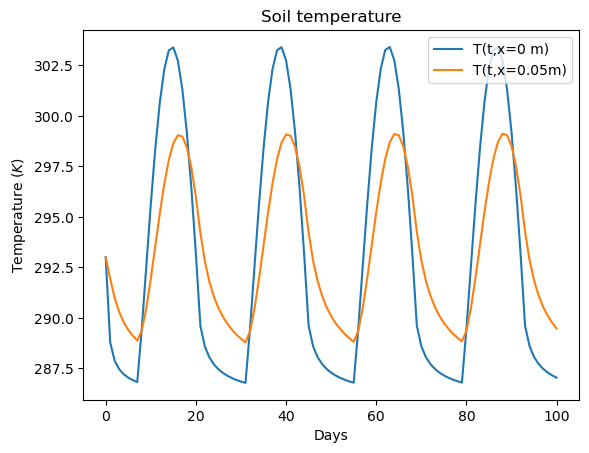

In [9]:
# Plot temperature 
dates = time_1hr/hour
plt.plot(dates,T1_array_output_1hr.detach().numpy(),label='T(t,x=0 m)')
plt.plot(dates,T2_array_output_1hr.detach().numpy(),label='T(t,x=0.05m)')
plt.legend()
plt.title('Soil temperature')
plt.xlabel('Days')
plt.ylabel(r'Temperature ($K$)')

## 5. Save results

In [10]:
#Save calculated temperature series so that we can use it for the inverse models
with open('Target_T1.txt','w') as outfile:
    np.savetxt(outfile,T1_array_output_1hr.detach().numpy(),fmt='%-7.6e')

with open('Target_T2.txt','w') as outfile:
    np.savetxt(outfile,T2_array_output_1hr.detach().numpy(),fmt='%-7.6e')